```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](/_static/pdf/Lecture21-QuantumMechanics.pdf)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the normalisation factor with trapezoidal rule
def integral_psi2(psi, dx):
    N = len(psi) - 1
    ret = 0
    
    for k in range(N):
        ret += psi[k] * np.conj(psi[k]) + psi[k+1] * np.conj(psi[k+1])
    
    ret *= 0.5 * dx
    
    return ret

# Compute the integral (to determine the sign)
def integral_psi(psi, dx):
    N = len(psi) - 1
    ret = 0
    
    for k in range(N//2):
        ret += psi[k] + psi[k+1]
    
    ret *= 0.5 * dx
    
    return ret

# Time dependent Schrödinger equation

## Time evolution of free particle wave function

The time-dependent Schrödinger equation reads

$$
\hat{H} \psi = i \hbar \frac{\partial \psi}{\partial t}~.
$$

e.g. for a free particle it reads

$$
-\frac{\hbar^2}{2m} \frac{\partial^2 \psi}{\partial x^2} = i \hbar \frac{\partial \psi}{\partial t}~.
$$

Formal solution be written as

$$
\psi(t) = e^{-\frac{it}{\hbar} \hat{H}} \psi(0),
$$

with $\hat{U}(t) =  e^{-\frac{it}{\hbar} \hat{H}}$ being the time evolution operator.
It is a unitary operator $U^\dagger U = \hat{I}$, therefore, the norm of the wave function $|\psi|^2$ is conserved.

We can study time evolution by successively applying approximate $\hat{U}(\Delta t)$ over small time intervals.
We can use the same schemes we learned for solving PDEs such as wave equation.
The only difference is that now we are dealing with complex-valued functions.

### FTCS scheme

$$
\hat{U}(\Delta t) = e^{-\frac{i \Delta t}{\hbar} \hat{H}} \approx 1 - \frac{i \Delta t}{\hbar} \hat{H}
$$

Such an operator is not unitary since

$$
U^\dagger (\Delta t) = 1 + \frac{i \Delta t}{\hbar} \hat{H} \neq \hat{U}(\Delta t).
$$

If $U$ is applied to an energy eigenstate $\psi_l$, such that $\hat{H} \psi_l = E_l \psi_l$, we get

$$
\psi_l(N \Delta t) = \lambda_l^N \psi_l(0),
$$

where $\lambda_l = \left[1 - \frac{i \Delta t E_l}{\hbar} \right]$.
Since $|\lambda_l| > 1$, the method is unstable.

### Implicit scheme

We apply the approximation of the FTCS scheme to the inverse of $\hat{U}(\Delta t)$.
This implies

$$
\hat{U}(\Delta t) = e^{-\frac{i \Delta t}{\hbar} \hat{H}} \approx \frac{1}{1 + \frac{i \Delta t}{\hbar} \hat{H}}.
$$

The operator is also non-unitary. The method is stable because

$$
|\lambda_l| = \left| \frac{1}{1 + \frac{i \Delta t}{\hbar} E_l} \right| < 1,
$$

but the method does not conserve the norm of the wave function.

### Crank-Nicholson scheme

Crank-Nicholson scheme takes the combination of FTCS and implicit schemes.
This corresponds to a rational approximation of $\hat{U}(\Delta t)$:

$$
\hat{U}(\Delta t) = e^{-\frac{i \Delta t}{\hbar} \hat{H}} \approx \frac{1 - \frac{i \Delta t}{2\hbar} \hat{H}}{1 + \frac{i \Delta t}{2\hbar} \hat{H}}.
$$

This operator is **unitary** (for an hermitian $\hat{H}$), $U^\dagger U = U U^\dagger$, and conserves the norm of the wave function.

Let us consider the particle in a box of length $L$.
We thus have boundary conditions $\psi(0) = \psi(L) = 0$.

Given some initial wave function $\psi(x)$, we can numerically integrate the Schrödinger equation to study the time evolution of the wave function.

Let us write the equation in a form:

$$
\frac{\partial \psi}{\partial t} = \frac{i \hbar}{2m} \frac{\partial^2 \psi}{\partial x^2}.
$$

We can now use the central difference approximation for $\partial^2 \psi / \partial x^2$:

$$
\frac{\partial^2 \psi}{\partial x^2} \approx \frac{1}{a^2} \left[ \psi(x+a,t) - 2 \psi(x,t) + \psi(x-a,t) \right].
$$

This gives us discretized wave function in coordinate space, in full analogy to the heat equation that we studied before. The only difference is that now we are dealing with complex-valued functions.

We now need to apply the prescription for time evolution.
The options are:
- FTCS scheme

$$
\psi(x,t+h) = \psi(x,t) + h \frac{i \hbar}{2ma^2} \left[ \psi(x+a,t) - 2 \psi(x,t) + \psi(x-a,t) \right],
$$

or

$$
\psi^{n+1}_k = \psi^n_k + h \frac{i \hbar}{2ma^2} (\psi^n_{k+1} - 2 \psi^n_k + \psi^n_{k-1}).
$$

- Implicit scheme

$$
\psi^{n+1}_k = \psi^n_k + h \frac{i \hbar}{2ma^2} (\psi^{n+1}_{k+1} - 2 \psi^{n+1}_k + \psi^{n+1}_{k-1}).
$$

- Crank-Nicholson scheme

$$
\psi^{n+1}_k = \psi^n_k + \frac{h}{2} \frac{i \hbar}{2ma^2} (\psi^n_{k+1} - 2 \psi^n_k + \psi^n_{k-1}) + \frac{h}{2} \frac{i \hbar}{2ma^2} (\psi^{n+1}_{k+1} - 2 \psi^{n+1}_k + \psi^{n+1}_{k-1}).
$$

To preserve unitarity it makes sense to apply Crank-Nicholson scheme.
In this case we need to solve the tridiagonal system of equations at each time step.

In [2]:
import numpy as np

# Solve tridiagonal system of linear equations
#  d: vector of diagonal elements
#  l: vector of elements on the lower subdiagonal
#  u: vector of elements on the upper superdiagonal
# v0: right-hand-side vector
def linsolve_tridiagonal(d, l, u, v0):
    # Initialization
    N = len(v0)
    a = d.copy() # Current diagonal elements
    b = u.copy() # Current upper diagonal elements
    v = v0.copy()
    
    # Gaussian elimination
    for r in range(N):
        if (a[r] == 0.):
            print("Diagonal element is zero! Cannot solve the tridiagonal system with simple Gaussian elimination")
            return None
        b[r] /= a[r]
        v[r] /= a[r]
        a[r] = 1.
        if (r < N - 1):
            a[r + 1] -= l[r+1] * b[r]
            v[r + 1] -= l[r+1] * v[r]
            
    # Backsubstitution
    x = np.empty(N,dtype=np.cdouble)
    
    x[N - 1] = v[N - 1]
    for r in range(N-2,-1,-1):
        x[r] = v[r] - b[r] * x[r + 1]
            
    return x

## Implementation

Let us implement the time evolution of a free particle wave function using the difference schemes.

In [3]:
me   = 9.1094e-31  # Mass of electron in kg
hbar = 1.0546e-34  # Planck's constant over 2*pi

# Single Crank-Nicholson scheme iteration for the Schroedinger equation
# psi is a complex-valued wave function discretized in space
# r = i * h * hbar / (2*m*a^2)
# scheme: 0 - FTCS, 1 - implicit, 2 - Crank-Nicholson
def schrodinger_finitediff_iteration(psi, r, scheme = 2):
    N = len(psi) - 1
    
    psinew = np.empty_like(psi, dtype=np.cdouble)
    
    # Boundary conditions
    psinew[0] = psi[0]
    psinew[N] = psi[N]
    
    if (scheme == 0):
        for i in range(1,N):
            psinew[i] = psi[i] + r * (psi[i+1] - 2 * psi[i] + psi[i-1])
    elif (scheme == 1):
        d  = np.full(N-1, 1 + 2*r)
        ud = np.full(N-1, -r)
        ld = np.full(N-1, -r)

        # Implicit scheme matrix
        v = np.array(psi[1:N])
        v[0]   += r * psi[0]
        v[N-2] += r * psi[N]

        # Solve tridiagonal system
        psinew[1:N] = linsolve_tridiagonal(d, ld, ud, v)
    else:
        d  = np.full(N-1, 2*(1+r))
        ud = np.full(N-1, -r)
        ld = np.full(N-1, -r)

        # Crank-Nicolson explicit step
        v = psi[1:N]*2*(1-r) + psi[:-2]*r + psi[2:]*r
        v[0]   += r * psi[0]
        v[N-2] += r * psi[N]

        # Solve tridiagonal system
        psinew[1:N] = linsolve_tridiagonal(d, ld, ud, v)
    
    return psinew

def schrodinger_finitediff_solve(psi0, h, nsteps, a, m = me, scheme = 2):
    psi = psi0.copy()
    r = 1j * h * hbar / (2 * m * a**2)
    for i in range(nsteps):
        psi = schrodinger_finitediff_iteration(psi, r, scheme)
        
    return psi


Initial condition is a Gaussian wave packet moving to the right.

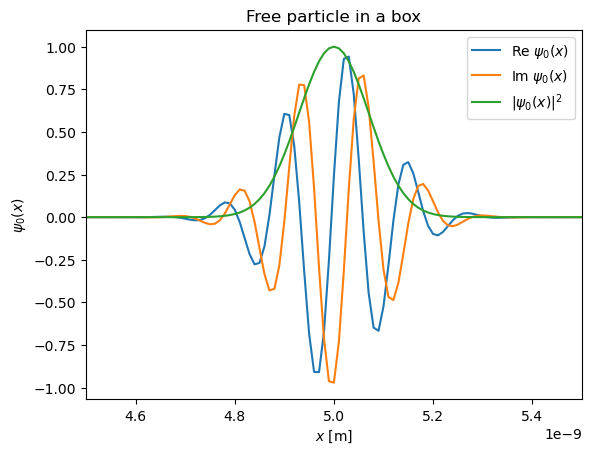

In [4]:
L = 1e-8 # m
x0 = L / 2.
sig = 1e-10 # m
kappa = 5e10 # m^-1

# Number of grid points
N = 1000
dx = L / N

# Initial wave function
def psi0(x):
    return np.exp(-(x-x0)**2/(2*sig**2))*np.exp(1j*kappa*x)

xk = []
psi = np.zeros([N+1],dtype=np.cdouble)
for k in range(N+1):
    x = dx * k
    xk.append(x)
    #print(x," ",x0," ", psi0(x))
    psi[k] = psi0(x)
psi[0] = 0
psi[N] = 0

norm0 = integral_psi2(psi, dx)

import matplotlib.pyplot as plt
plt.title("Free particle in a box")
plt.xlabel('${x}$ [m]')
plt.ylabel('${\psi_0(x)}$')
plt.xlim(L/2 - 0.05*L,L/2 + 0.05*L)
plt.plot([dx*k for k in range(N+1)], np.real(psi), label="Re ${\psi_0(x)}$")
plt.plot([dx*k for k in range(N+1)], np.imag(psi), label="Im ${\psi_0(x)}$")
plt.plot([dx*k for k in range(N+1)], np.abs(psi)**2, label="$|{\psi_0(x)|^2}$")
plt.legend()
plt.show()

Now integrate over time

### FTCS scheme

In [5]:
xk = []
psi = np.zeros([N+1],dtype=np.cdouble)
for k in range(N+1):
    x = dx * k
    xk.append(x)
    #print(x," ",x0," ", psi0(x))
    psi[k] = psi0(x)
psi[0] = 0
psi[N] = 0

current_time = 0.
h = 1e-19
nsteps = 18
scheme = 0 # 0 - FTCS, 1 - implicit, 2 - Crank-Nicholson
for i in range(100):
    psi = schrodinger_finitediff_solve(psi, h, nsteps, dx, me, scheme)
    current_time += h * nsteps

![](schrodinger_equation_1D_pulse_FTCS.gif)

In [6]:
from matplotlib.animation import FuncAnimation

xk = []
psi = np.zeros([N+1],dtype=np.cdouble)
for k in range(N+1):
    x = dx * k
    xk.append(x)
    #print(x," ",x0," ", psi0(x))
    psi[k] = psi0(x)
psi[0] = 0
psi[N] = 0

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Schroedinger equation (FTCS)", fontsize = 18)
current_time = 0

ax.set_xlabel('${x}$ [m]')
ax.set_ylabel('${\psi(x)}$')
line = ax.plot(xk,np.abs(psi)**2, label="${|\psi_0(x)}|^2$, norm = " + '{:.5f}'.format(integral_psi2(psi,dx)/norm0))[0]
title = ax.set_title("Schroedinger equation (FTCS)")
plt.legend(loc="upper right")
plt.xlim(0,L)
plt.ylim(-1.1,1.1)

scheme = 0

def animate_schrodinger_equation_FTCS(i):
    global fps, tottime, tend
    nsteps = 6
    global psi, current_time
    psi = schrodinger_finitediff_solve(psi, h, nsteps, dx, me, scheme)
    current_time += h * nsteps
    title.set_text("t = " + '{:.1f}'.format(current_time*1.e18) + " as")
    line.set_ydata(np.abs(psi)**2)
    L = ax.legend()
    L.get_texts()[0].set_text("${|\psi_0(x)}|^2$, norm = " + '{:.5f}'.format(integral_psi2(psi,dx)/norm0))
    return [line, title, L]

fps = 30
tottime = 10.
ani = FuncAnimation(fig, animate_schrodinger_equation_FTCS, frames=round(fps * tottime), interval=1000/fps, repeat=False)
plt.close();

# ani.save("schrodinger_equation_1D_pulse.gif")

# from IPython.display import HTML
# HTML(ani.to_jshtml(default_mode="loop"))

The divergence of the FTCS scheme is evident.

### Implicit scheme

Implicit scheme is more stable but it does not conserve the norm of the wave function, which decreases over time.

![](schrodinger_equation_1D_pulse_implicit.gif)

In [7]:
from matplotlib.animation import FuncAnimation

xk = []
psi = np.zeros([N+1],dtype=np.cdouble)
for k in range(N+1):
    x = dx * k
    xk.append(x)
    #print(x," ",x0," ", psi0(x))
    psi[k] = psi0(x)
psi[0] = 0
psi[N] = 0

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Schroedinger equation (Implicit Scheme)", fontsize = 18)
current_time = 0

ax.set_xlabel('${x}$ [m]')
ax.set_ylabel('${\psi(x)}$')
line = ax.plot(xk,np.abs(psi)**2, label="${|\psi_0(x)}|^2$, norm = " + '{:.5f}'.format(integral_psi2(psi,dx)/norm0))[0]
title = ax.set_title("Schroedinger equation (Implicit)")
plt.legend(loc="upper right")
plt.xlim(0,L)
plt.ylim(-1.1,1.1)

scheme = 1

fps = 30
tottime = 10.
ani = FuncAnimation(fig, animate_schrodinger_equation_FTCS, frames=round(fps * tottime), interval=1000/fps, repeat=False)
plt.close();

# ani.save("schrodinger_equation_1D_pulse_implicit.gif")

# from IPython.display import HTML
# HTML(ani.to_jshtml(default_mode="loop"))

/opt/anaconda3/envs/CompPhys/lib/python3.10/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


### Crank-Nicholson scheme

Crank-Nicholson scheme is a second-order accurate scheme that is unconditionally stable and conserves the norm of the wave function.

![](schrodinger_equation_1D_pulse_CN.gif)

In [8]:
from matplotlib.animation import FuncAnimation

xk = []
psi = np.zeros([N+1],dtype=np.cdouble)
for k in range(N+1):
    x = dx * k
    xk.append(x)
    #print(x," ",x0," ", psi0(x))
    psi[k] = psi0(x)
psi[0] = 0
psi[N] = 0

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Schroedinger equation (Crank-Nicholson Scheme)", fontsize = 18)
current_time = 0

ax.set_xlabel('${x}$ [m]')
ax.set_ylabel('${\psi(x)}$')
line = ax.plot(xk,np.abs(psi)**2, label="${|\psi_0(x)}|^2$, norm = " + '{:.5f}'.format(integral_psi2(psi,dx)/norm0))[0]
title = ax.set_title("Schroedinger equation (Implicit)")
plt.legend(loc="upper right")
plt.xlim(0,L)
plt.ylim(-1.1,1.1)

scheme = 2

fps = 30
tottime = 10.
ani = FuncAnimation(fig, animate_schrodinger_equation_FTCS, frames=round(fps * tottime), interval=1000/fps, repeat=False)
plt.close();

# ani.save("schrodinger_equation_1D_pulse_CN.gif")

# from IPython.display import HTML
# HTML(ani.to_jshtml(default_mode="loop"))